In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
import statsmodels.api as sm
import DataSplitter
import utils

# Naive benchmark

In [19]:
df60 = DataSplitter.getTrainData(60)
df60_line = df60[df60['line'] == '1A']
df60_line = df60_line.reset_index(drop=True)

train60, val60 = DataSplitter.performTrainValSplit(df60_line)
train60_line = train60.reset_index(drop=True)
val60_line = val60.reset_index(drop=True)

target = 'passengersBoarding'
dropCols = ['date', 'hour', 'year', 'quarter', 'Q1', 'month', 'monthNumber', 'weekNumber', 'weekDay', 
            'dateNumber', 'mon', 'workdayPlan', 'line', 'passengersBoarding', 'eventName', 'datetime']

train_index = pd.RangeIndex(start=0, stop=train60_line.shape[0])
val_index = pd.RangeIndex(start=train60_line.shape[0], stop=train60_line.shape[0]+val60_line.shape[0])

X_train = train60_line.drop(columns=dropCols, axis=1)
y_train = train60_line[target]
X_val = val60_line.drop(columns=dropCols, axis=1)
y_val = val60_line[target]

X_train.index = train_index
y_train.index = train_index
X_val.index = val_index
y_val.index = val_index

RangeIndex(start=14660, stop=14680, step=1)
RangeIndex(start=14700, stop=14720, step=1)
RangeIndex(start=14740, stop=14760, step=1)
RangeIndex(start=14780, stop=14800, step=1)
RangeIndex(start=14820, stop=14840, step=1)
RangeIndex(start=14860, stop=14880, step=1)
RangeIndex(start=14900, stop=14920, step=1)
RangeIndex(start=14940, stop=14960, step=1)
RangeIndex(start=14980, stop=15000, step=1)
RangeIndex(start=15020, stop=15040, step=1)
RangeIndex(start=15060, stop=15080, step=1)
RangeIndex(start=15100, stop=15120, step=1)
RangeIndex(start=15140, stop=15160, step=1)
RangeIndex(start=15180, stop=15200, step=1)
RangeIndex(start=15220, stop=15240, step=1)
RangeIndex(start=15260, stop=15280, step=1)
RangeIndex(start=15300, stop=15320, step=1)
RangeIndex(start=15340, stop=15360, step=1)
RangeIndex(start=15380, stop=15400, step=1)
RangeIndex(start=15420, stop=15440, step=1)
RangeIndex(start=15460, stop=15480, step=1)
RangeIndex(start=15500, stop=15520, step=1)
RangeIndex(start=15540, stop=155

/var/folders/93/9bwp5y9s6p925yjm6qkgky980000gn/T/ipykernel_64862/877750355.py:24: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  preds_1step = pd.concat([preds_1step, pred])
/var/folders/93/9bwp5y9s6p925yjm6qkgky980000gn/T/ipykernel_64862/877750355.py:26: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  y_val_pred = pd.concat([y_val_pred, preds_1step])


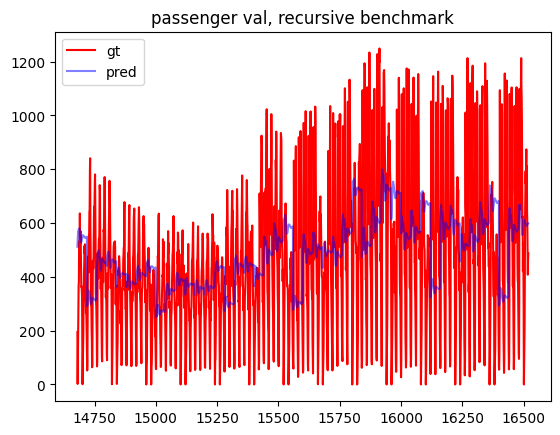

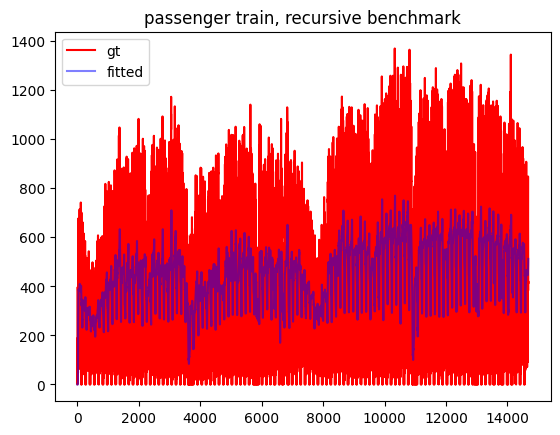

In [20]:
horizon = 40*1
window_size = 20*1
y_val_pred = pd.Series()
indexrange = range(y_val.index[0], y_val.index[-1] + 1, horizon)

# concat all train and val data so it can be subsetted on window
X_sliding = pd.concat([X_train, X_val])
y_sliding = pd.concat([y_train, y_val])

timer = utils.Time()
timer.start()
for idx, time in enumerate(indexrange):
    # subset on window size
    y_temp = y_sliding.loc[time - window_size : time-1]
    print(y_temp.index)

    preds_1step = pd.Series()
    for i in range(0, horizon):
        # 1 step prediction
        pred = pd.Series(y_temp.mean(), index=[time+i])

        # add new prediction and discard first datapoint
        y_temp = pd.concat([y_temp, pred])[1:]
        preds_1step = pd.concat([preds_1step, pred])

    y_val_pred = pd.concat([y_val_pred, preds_1step])
print(timer.end())

# train predictions as rolling mean
y_train_pred = y_train.rolling(window=window_size).mean().fillna(0)

# round and cut off train and val predictions
y_train_pred = y_train_pred.round()
y_train_pred[y_train_pred < 0] = 0
y_val_pred = y_val_pred.round()
y_val_pred[y_val_pred < 0] = 0

print('train MAE%:', utils.MAE(y=y_train, yhat=y_train_pred))
print('train MAPE:', utils.MAPE(y=y_train, yhat=y_train_pred))
print('train RMSE%:', utils.RMSE(y=y_train, yhat=y_train_pred))

print('val MAE%:', utils.MAE(y=y_val, yhat=y_val_pred))
print('val MAPE:', utils.MAPE(y=y_val, yhat=y_val_pred))
print('val RMSE%:', utils.RMSE(y=y_val, yhat=y_val_pred))

plt.plot(X_val.index, y_val, color='red', label='gt')
plt.plot(X_val.index, y_val_pred, color='blue', alpha=0.5, label='pred')
#plt.xticks(range(y_val.index[0], y_val.index[-1] + 1, horizon*3), val60_line['datetime'].values[::horizon*3], rotation=90)
plt.title('passenger val, recursive benchmark')
plt.legend()
plt.show()

plt.plot(X_train.index, y_train, color='red', label='gt')
plt.plot(X_train.index, y_train_pred, color='blue', alpha=0.5, label='fitted')
plt.title('passenger train, recursive benchmark')
plt.legend()
plt.show()

# Lasso

In [21]:
df60 = DataSplitter.getTrainData(60)
df60_line = df60[df60['line'] == '1A']
df60_line = df60_line.reset_index(drop=True)

train60, val60 = DataSplitter.performTrainValSplit(df60_line)
train60_line = train60.reset_index(drop=True)
val60_line = val60.reset_index(drop=True)

target = 'passengersBoarding'
dropCols = ['date', 'hour', 'year', 'quarter', 'Q1', 'month', 'monthNumber', 'weekNumber', 'weekDay', 
            'dateNumber', 'mon', 'workdayPlan', 'line', 'passengersBoarding', 'eventName', 'datetime']

train_index = pd.RangeIndex(start=0, stop=train60_line.shape[0])
val_index = pd.RangeIndex(start=train60_line.shape[0], stop=train60_line.shape[0]+val60_line.shape[0])

X_train = train60_line.drop(columns=dropCols, axis=1)
y_train = train60_line[target]
X_val = val60_line.drop(columns=dropCols, axis=1)
y_val = val60_line[target]

X_train.index = train_index
y_train.index = train_index
X_val.index = val_index
y_val.index = val_index

Execution time: 0.270 sec
train MAE%: 0.148
train MAPE: 0.261
train RMSE%: 0.207
val MAE%: 0.128
val MAPE: 0.249
val RMSE%: 0.175


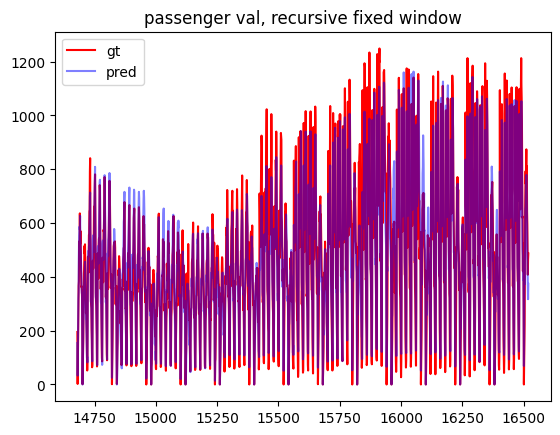

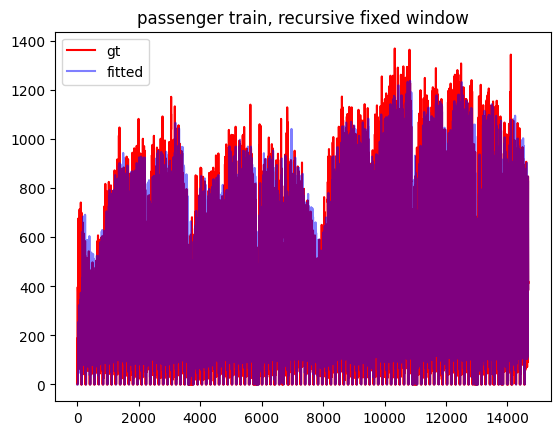

                            OLS Regression Results                            
Dep. Variable:     passengersBoarding   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     3482.
Date:                Mon, 11 Mar 2024   Prob (F-statistic):               0.00
Time:                        16:06:56   Log-Likelihood:                -87141.
No. Observations:               14680   AIC:                         1.743e+05
Df Residuals:                   14646   BIC:                         1.746e+05
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  362.9926 

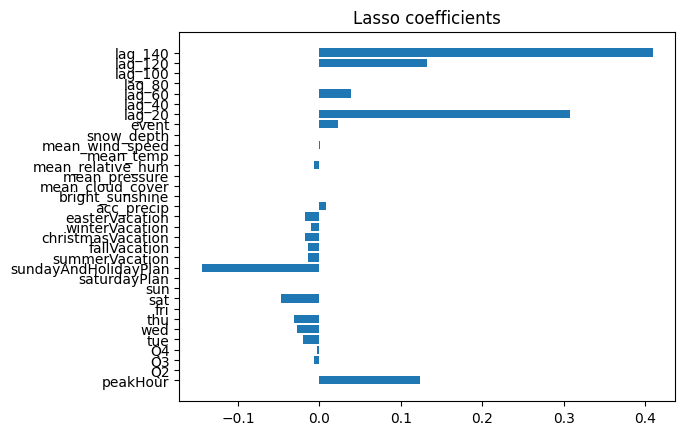

In [78]:
# fixed window
horizon = 40
lags = [20, 40, 60, 80, 100, 120, 140]
diff = None # None or 1

model = Lasso(alpha=0.01, fit_intercept=True, max_iter=1000)
scalar = StandardScaler()
exog_scalar = StandardScaler()

model, y_train_pred, y_val_pred = utils.fixedWindowForecastSklearn(
    X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, model=model,
    horizon=horizon, differentiation=diff, lags=lags, 
    scalar=scalar, exog_scalar=exog_scalar)

print('train MAE%:', utils.MAE(y=y_train, yhat=y_train_pred))
print('train MAPE:', utils.MAPE(y=y_train, yhat=y_train_pred))
print('train RMSE%:', utils.RMSE(y=y_train, yhat=y_train_pred))

print('val MAE%:', utils.MAE(y=y_val, yhat=y_val_pred))
print('val MAPE:', utils.MAPE(y=y_val, yhat=y_val_pred))
print('val RMSE%:', utils.RMSE(y=y_val, yhat=y_val_pred))

plt.plot(X_val.index, y_val, color='red', label='gt')
plt.plot(X_val.index, y_val_pred, color='blue', alpha=0.5, label='pred')
#plt.xticks(range(y_val.index[0], y_val.index[-1] + 1, horizon*3), val60_line['datetime'].values[::horizon*3], rotation=90)
plt.title('passenger val, recursive fixed window')
plt.legend()
plt.show()

plt.plot(X_train.index, y_train, color='red', label='gt')
plt.plot(X_train.index, y_train_pred, color='blue', alpha=0.5, label='fitted')
#plt.xticks(range(y_val.index[0], y_val.index[-1] + 1, horizon*3), val60_line['datetime'].values[::horizon*3], rotation=90)
plt.title('passenger train, recursive fixed window')
plt.legend()
plt.show()

# Use statsmodels to perform OLS regression and output summary
X_train_lagged = X_train.copy(deep=True)
if lags:
    for lag in lags:
        X_train_lagged[f'lag_{lag}'] = y_train.shift(periods=lag).fillna(0)
ols_model = sm.OLS(y_train, sm.add_constant(X_train_lagged)).fit()
print(ols_model.summary())

plt.barh(X_train_lagged.columns, model.coef_)
plt.title('Lasso coefficients')
plt.show()

# Lasso grid search

In [75]:
# fixed window forecast
import warnings
warnings.filterwarnings("ignore")

horizon = 40
bestMAE = 100000
laglist = [[1], [2], [3], [4], [5], [6], [7], [8], [20], [40], [60], [80], [100], [120], [140],
           [1, 20, 140], [1, 4, 7, 8, 20],
           [1, 20, 40, 60, 80, 100, 120, 140],
           [1, 2, 3, 4, 5, 6, 7, 8], [20, 40, 60, 80, 100, 120, 140]]

for diff in [1, None]:
    for lags in laglist:
        for alpha in [0.3, 0.2, 0.1, 0.05, 0.01]:
            model = Lasso(alpha=alpha, fit_intercept=True, max_iter=1000)
            scalar = StandardScaler()
            exog_scalar = StandardScaler()

            model, y_train_pred, y_val_pred = utils.fixedWindowForecastSklearn(
                X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, model=model,
                horizon=horizon, differentiation=diff, lags=lags, 
                scalar=scalar, exog_scalar=exog_scalar)

            trainMAE = utils.MAE(y=y_train, yhat=y_train_pred)
            valMAE = utils.MAE(y=y_val, yhat=y_val_pred)
            if valMAE < bestMAE:
                bestMAE = valMAE
                print(alpha, diff, lags)
                print('train MAE%:', utils.MAE(y=y_train, yhat=y_train_pred))
                print('train MAPE:', utils.MAPE(y=y_train, yhat=y_train_pred))
                print('train RMSE%:', utils.RMSE(y=y_train, yhat=y_train_pred))

                print('val MAE%:', utils.MAE(y=y_val, yhat=y_val_pred))
                print('val MAPE:', utils.MAPE(y=y_val, yhat=y_val_pred))
                print('val RMSE%:', utils.RMSE(y=y_val, yhat=y_val_pred))

Execution time: 0.279 sec
0.3 1 [1]
train MAE%: 0.278
train MAPE: 0.793
train RMSE%: 0.369
val MAE%: 0.673
val MAPE: 1.364
val RMSE%: 0.858
Execution time: 0.251 sec
Execution time: 0.264 sec
Execution time: 0.237 sec
0.05 1 [1]
train MAE%: 0.228
train MAPE: 0.553
train RMSE%: 0.308
val MAE%: 0.642
val MAPE: 1.303
val RMSE%: 0.826
Execution time: 0.252 sec
0.01 1 [1]
train MAE%: 0.218
train MAPE: 0.507
train RMSE%: 0.298
val MAE%: 0.622
val MAPE: 1.275
val RMSE%: 0.807
Execution time: 0.281 sec
Execution time: 0.255 sec
Execution time: 0.235 sec
Execution time: 0.227 sec
Execution time: 0.257 sec
0.01 1 [2]
train MAE%: 0.284
train MAPE: 0.711
train RMSE%: 0.363
val MAE%: 0.569
val MAPE: 1.192
val RMSE%: 0.741
Execution time: 0.245 sec
Execution time: 0.258 sec
Execution time: 0.261 sec
Execution time: 0.267 sec
Execution time: 0.236 sec
0.01 1 [3]
train MAE%: 0.296
train MAPE: 0.744
train RMSE%: 0.376
val MAE%: 0.514
val MAPE: 1.174
val RMSE%: 0.678
Execution time: 0.223 sec
Execution 

Best with 1-diff: alpha=0.01, diff=1, lag=[140]

train MAE: 0.168, train MAPE: 0.32, train RMSE: 0.238

val MAE: 0.19, val MAPE: 0.281, val RMSE: 0.257


Best without 1-diff: alpha=0.01, diff=None, lags=[20, 40, 60, 80, 100, 120, 140]

train MAE: 0.148, train MAPE: 0.261, train RMSE: 0.207

val MAE: 0.128, val MAPE: 0.249, val RMSE: 0.175